# Assignment 2: Regresssion

## Generate dataset

This code cell is responsible for generating an artificial dataset on which we perform analysis and regression problems.

### Description
The dataset contains 100 sample records and comprises of four features $x_1$, $x_2$, $x_3$, $x_4$ and target value $y$.
Each $x_i$ is a generated from a uniform RNG which generates numbers between $[-5, 5]$.

#### Generatiom of target values
Rather than using an arbitrary RNG for generating target $y$ values which might produce outliers, we specifically
compute them such that it is better tailored for regression problems.

We start off by generating an arbitrary weights vector $w$ sampled from a uniform RNG of $[-1, 1]$.
Then for each $X$ record, we take the dot product of the feature map of $X$ and $w$. This produces a scaler that is the target $y$ value for that record.

In [1]:
import numpy as np

n_samples = 100
n_inputs = 4
filename = "dataset.csv"

np.random.seed(42)
X = np.random.uniform(-5, 5, (n_samples, n_inputs))

def generate_y_values(X):
    w = np.random.uniform(-1, 1, 15)
    
    y = []
    for x in X:
        x1, x2, x3, x4 = x
        phi = [
            1,
            x1, x2, x3, x4,
            x1**2, x2**2, x3**2, x4**2,
            x1*x2, x1*x3, x1*x4,
            x2*x3, x2*x4, x3*x4
        ]
        y.append(np.dot(phi, w))
    return np.array(y)

y = generate_y_values(X)

dataset = np.column_stack((X, y))

np.savetxt(filename, dataset, delimiter=",", header="x1,x2,x3,x4,y")

print(f"Successfully saved {n_samples} samples to {filename}")

Successfully saved 100 samples to dataset.csv


## Load Dataset

In [2]:
import numpy as np

data = np.genfromtxt('dataset.csv', delimiter=',', skip_header=1)

X = data[:, :4]
y = data[:, 4]

## Generate Feature Map

The feature map transforms the input vector $X$ into a higher dimensional space where the non-linearity of the dataset can be modelled into a linear relationship.

The feature map is a vector whose size depend of the number of input features $d$ and required degree of polynomial $p$. The size is given by
$$
n = \binom{d + p}{p}
$$

For a dataset of 4 features (as generated before) and polynomial degree 2, the feature map has a length of 15.

In [3]:
def calculate_feature_map(X):
    N = X.shape[0]
    Phi = np.zeros((N, 15))
    
    for i in range(N):
        x1, x2, x3, x4 = X[i]
        phi_row = [
            1,
            x1, x2, x3, x4,
            x1**2, x2**2, x3**2, x4**2,
            x1*x2, x1*x3, x1*x4,
            x2*x3, x2*x4, 
            x3*x4
        ]
        Phi[i, :] = phi_row
        
    return Phi

Phi = calculate_feature_map(X)

print(f"Shape of original input X: {X.shape}")
print(f"Shape of feature map Phi: {Phi.shape}")
print(f"Dimension of phi(x): {Phi.shape[1]}")

Shape of original input X: (100, 4)
Shape of feature map Phi: (100, 15)
Dimension of phi(x): 15


## Cost function
We use a mean squared error approaach to calculate the errors

In [4]:
N, D = Phi.shape 

w = np.zeros(D)

def compute_cost(w):
    predictions = Phi @ w
    errors = predictions - y
    cost = (1 / (2 * N)) * np.sum(errors**2)
    return cost

initial_cost = compute_cost(w)

print(f"Decision Variable w Dimension: {w.shape[0]}") 
print(f"Initial Cost with zero weights: {initial_cost:.4f}")

Decision Variable w Dimension: 15
Initial Cost with zero weights: 159.0396


## Gradient of the Cost function

The derivative of the mean-squared error cost function is
$$
\nabla_w J(w) = \frac{1}{N} \Phi^T \cdot (\Phi w - y)
$$

In [5]:
def compute_gradient(w):
    predictions = Phi @ w
    error = predictions - y
    gradient = (1/N) * (Phi.T @ error)
    return gradient

w_current = np.zeros(D)
grad = compute_gradient(w_current)

print(f"Gradient vector shape: {grad.shape}")
print(f"Gradient: {grad}")

Gradient vector shape: (15,)
Gradient: [  -3.66837953    0.54893695   -7.14272155   -4.18312741    6.66303949
 -103.8201483   -31.368363     16.78735677  -70.36197739   55.21978481
   20.73157586  -43.88773544  -66.18781127  -42.76360873  -36.09771729]


In [6]:
import cvxpy as cp

w = cp.Variable(D)

objective = cp.Minimize((0.5 / N) * cp.sum_squares(Phi @ w - y))
prob = cp.Problem(objective)
prob.solve()
w_opt = w.value

terms = [
    "1", "x1", "x2", "x3", "x4", 
    "x1^2", "x1x2", "x1x3", "x1x4", 
    "x2^2", "x2x3", "x2x4", 
    "x3^2", "x3x4", 
    "x4^2"
]

print("The polynomial mapping determined using QP solver is:")
polynomial_str = " + ".join([f"({val:.4f})*{name}" for val, name in zip(w_opt, terms)])
print(f"y = {polynomial_str}")

The polynomial mapping determined using QP solver is:
y = (-0.7938)*1 + (0.8051)*x1 + (0.0105)*x2 + (0.6529)*x3 + (-0.3599)*x4 + (0.7910)*x1^2 + (-0.2216)*x1x2 + (-0.9783)*x1x3 + (0.8108)*x1x4 + (-0.8174)*x2^2 + (-0.3614)*x2x3 + (0.9001)*x2x4 + (0.9012)*x3^2 + (0.1469)*x3x4 + (0.2637)*x4^2


## Verifying the optimal weights

- First we cslculate the optimal weights
- THen doing the predictions based on the obtained weights
- Next we take the actual values and computed predictions and calculate the absolute error between those
- Finally we plot them using `matplotlib`

The obtained optimal weights are: [-0.79375226  0.80510581  0.01050474  0.65291493 -0.3599008   0.79104646
 -0.22159664 -0.9783247   0.81076395 -0.81742665 -0.36137272  0.90012393
  0.90121429  0.14687578  0.26367442]


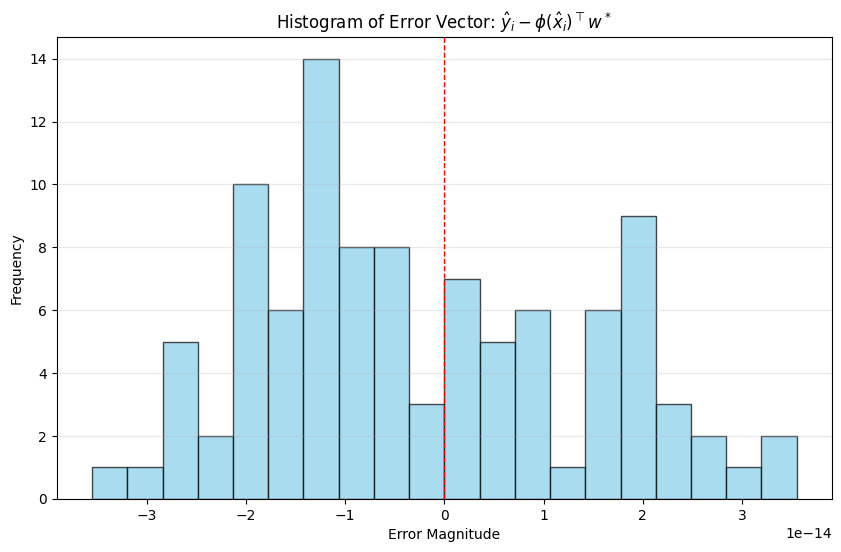

In [9]:
import matplotlib.pyplot as plt

w_opt = np.linalg.solve(Phi.T @ Phi, Phi.T @ y)
print("The obtained optimal weights are:", w_opt)

predictions = Phi @ w_opt
error_vector = y - predictions

# 3. Plot the histogram of errors
plt.figure(figsize=(10, 6))
plt.hist(error_vector, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
plt.title(r'Histogram of Error Vector: $\hat{y}_i - \phi(\hat{x}_i)^\top w^*$')
plt.xlabel('Error Magnitude')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
plt.savefig("fig1.png", bbox_inches='tight')
plt.show()

In [10]:
max_steps = 1000
w_0 = np.zeros(D)

eigvals = np.linalg.eigvalsh(Phi.T @ Phi)
L = 2 * np.max(eigvals)

beta = np.max(eigvals)
alp = np.min(eigvals)
gamma = (np.sqrt(beta / alp) - 1) / (np.sqrt(beta / alp) + 1)

# Hyperparameters (tuned for stability)
eta = 1 / np.max(eigvals)
eta = 1 / np.max(eigvals)

# Storage for plotting
history = {
    'gd':  {'cost': [], 'error': []},
    'agd': {'cost': [], 'error': []},
    'sgd': {'cost': [], 'error': []}
}

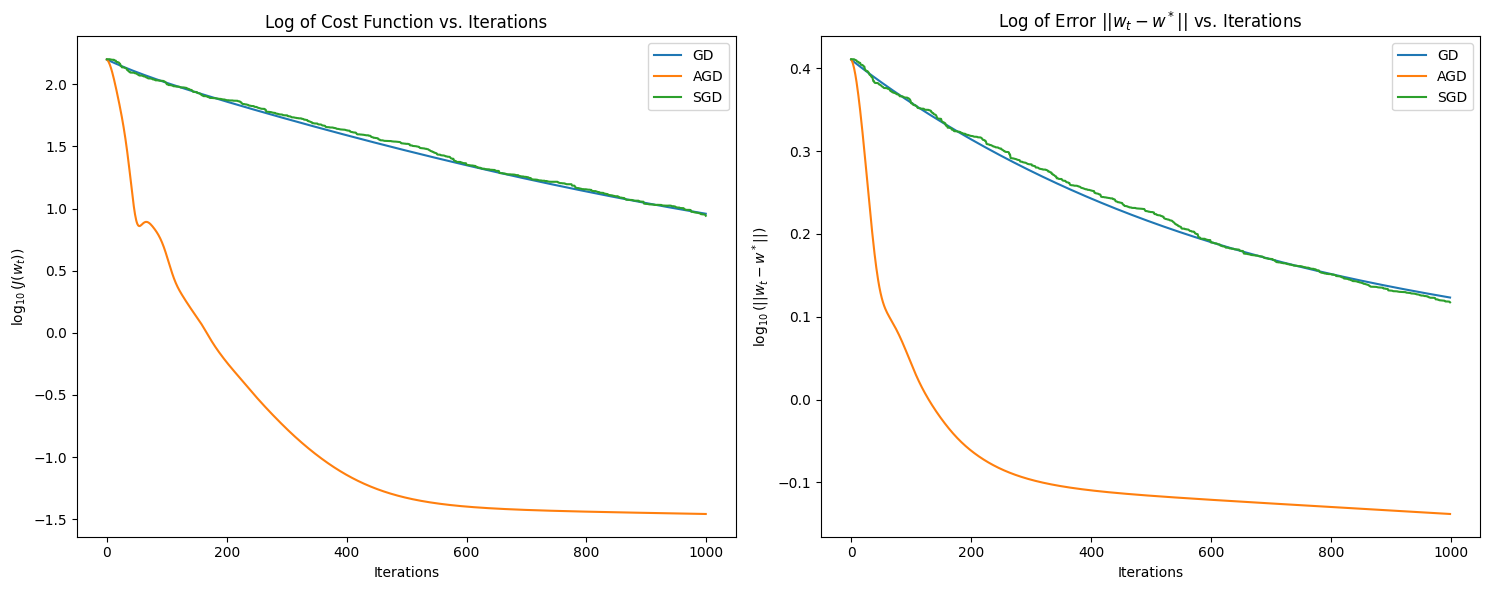

In [12]:
w_0 = np.zeros(D)

# --- 1. Gradient Descent (GD) ---
w_t = w_0.copy()
for t in range(max_steps):
    grad = compute_gradient(w_t)
    w_t = w_t - eta * grad
    history['gd']['cost'].append(compute_cost(w_t))
    history['gd']['error'].append(np.linalg.norm(w_t - w_opt))

# --- 2. Accelerated Gradient Descent (AGD) ---
w_t = w_0.copy()
v_t = w_0.copy()
for t in range(max_steps):
    w_prev = w_t.copy()
    y_t = w_t + gamma * (w_t - v_t) if t > 0 else w_t
    w_t = y_t - eta * compute_gradient(y_t)
    v_t = w_prev
    history['agd']['cost'].append(compute_cost(w_t))
    history['agd']['error'].append(np.linalg.norm(w_t - w_opt))

# --- 3. Stochastic Gradient Descent (SGD) ---
# Gradient function for Stochastic Gradient (for SGD)
def get_grad_sgd(w, indices):
    Phi_i = Phi[indices]
    y_i = y[indices]
    return Phi_i.T * (Phi_i @ w - y_i)

w_t = w_0.copy()
for t in range(max_steps):
    idx = np.random.randint(0, N) # Pick one sample 
    grad = get_grad_sgd(w_t, [idx])
    grad = grad.flatten()
    w_t = w_t - eta * grad
    history['sgd']['cost'].append(compute_cost(w_t))
    history['sgd']['error'].append(np.linalg.norm(w_t - w_opt))

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for label, data in history.items():
    ax1.plot(np.log10(data['cost']), label=label.upper())
    ax2.plot(np.log10(data['error']), label=label.upper())

ax1.set_title('Log of Cost Function vs. Iterations')
ax1.set_xlabel('Iterations')
ax1.set_ylabel(r'$\log_{10}(J(w_t))$')
ax1.legend()

ax2.set_title('Log of Error $||w_t - w^*||$ vs. Iterations')
ax2.set_xlabel('Iterations')
ax2.set_ylabel(r'$\log_{10}(||w_t - w^*||)$')
ax2.legend()

plt.tight_layout()
plt.savefig("fig2.png", bbox_inches='tight')
plt.show()

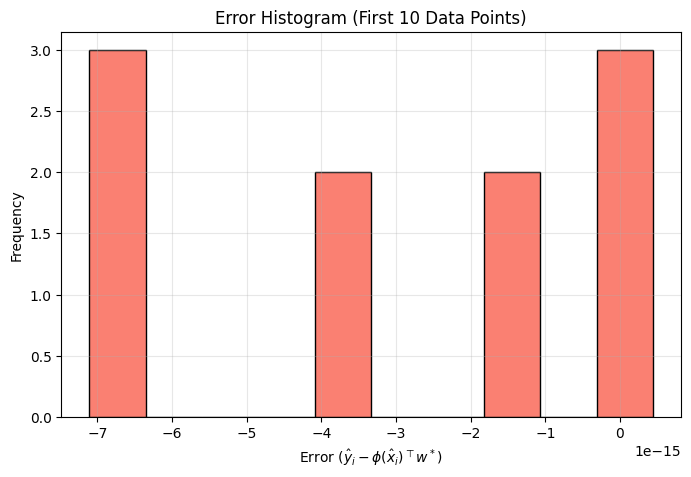

In [13]:
# 1. Use only the first 10 data points
Phi_10 = Phi[:10, :]
y_10 = y[:10]

# 2. Define the decision variable w (still dimension 15)
w_10 = cp.Variable(D)

# 3. Formulate the Cost Function
objective_10 = cp.Minimize((0.5 / 10) * cp.sum_squares(Phi_10 @ w_10 - y_10))

# 4. Solve
prob_10 = cp.Problem(objective_10)
prob_10.solve()

w_opt_10 = w_10.value

# 5. Compute Error Vector and Plot Histogram
# error = y_actual - y_predicted
errors_10 = y_10 - (Phi_10 @ w_opt_10)

plt.figure(figsize=(8, 5))
plt.hist(errors_10, bins=10, color='salmon', edgecolor='black')
plt.title('Error Histogram (First 10 Data Points)')
plt.xlabel(r'Error ($\hat{y}_i - \phi(\hat{x}_i)^\top w^*$)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.savefig("fig3.png", bbox_inches='tight')
plt.show()

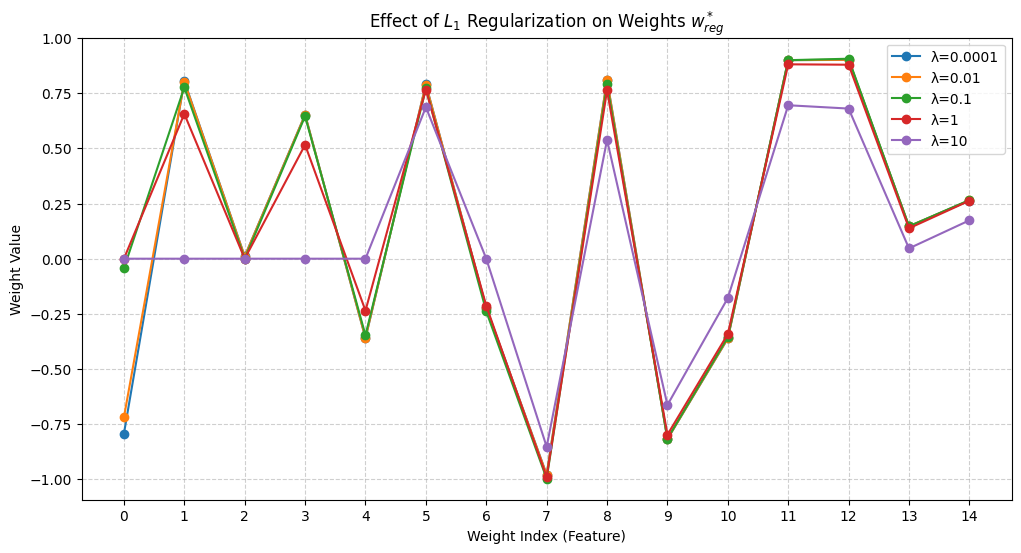

In [14]:
# 1. Define range of regularization weights (lambda)
lambdas = [1e-4, 1e-2, 0.1, 1, 10]
w_reg_results = []

w_var = cp.Variable(D)

# 3. Solve for each lambda
for lam in lambdas:
    # Cost = MSE + lambda * L1_norm(w)
    mse_term = (0.5 / N) * cp.sum_squares(Phi @ w_var - y)
    reg_term = lam * cp.norm(w_var, 1)
    
    objective = cp.Minimize(mse_term + reg_term)
    prob = cp.Problem(objective)
    prob.solve()
    
    w_reg_results.append(w_var.value)

# 4. Visualization of Weight Sparsity
plt.figure(figsize=(12, 6))
for i, lam in enumerate(lambdas):
    plt.plot(range(D), w_reg_results[i], marker='o', label=f'λ={lam}')

plt.title('Effect of $L_1$ Regularization on Weights $w_{reg}^*$')
plt.xlabel('Weight Index (Feature)')
plt.ylabel('Weight Value')
plt.xticks(range(D))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("fig4.png", bbox_inches='tight')
plt.show()